In [13]:
import numpy as np
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
%matplotlib inline

In [14]:
def load_data(df, test_year):
    
    train = df.loc[df["year"] != test_year]
    test = df.loc[df["year"] == test_year]
    
    # 入力データの作成
    y_train = train['prize'].ravel()
    x_train = train.drop(['prize', 'year'], axis=1)
    
    features = x_train.columns
    
    x_train = x_train.values # 学習データ
    
    # テストデータの作成
    y_test = test['prize'].ravel()
    x_test = test.drop(['prize', 'year'], axis=1)
    x_test = x_test.values # テストデータ
    
    return x_train, x_test, y_train, y_test, features

In [15]:
def print_weight_map(weight, features):
    # feature importance
    feature_imp = weight.reshape(features.shape)
    feature_imp_arg = np.argsort(feature_imp)
    f_num = len(feature_imp_arg)
    plt.rcParams["font.family"] = "IPAexGothic"
    plt.figure(figsize=(20,20))
    plt.barh(range(len(feature_imp_arg)), feature_imp[feature_imp_arg], color='b', align='center')
    plt.yticks(range(len(feature_imp_arg)), features[feature_imp_arg])
    plt.show()

In [16]:
def plot_roc_curve(fpr, tpr, auc):
    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

In [39]:
# optunaで最適なC_valを探す

def train():
    
    df =  pd.read_pickle('../../data/dataframes/pos_val_df.pkl')
    
    th_prob = 0.5
    
    cm_all = np.zeros((2, 2))
    
    # 予測した確率全体を格納
    probs_all = np.array([])
    y_true_all = np.array([])
    
    for y in range(1978, 2020):
        
        # データの生成
        x_train_std, x_test_std, y_train, y_test, features = load_data(df, y)
        
        # 学習
        lr = LogisticRegression(class_weight="balanced", solver="liblinear",  penalty="l1", C=0.1) # ロジスティック回帰モデルのインスタンスを作成
        lr.fit(x_train_std, y_train) # ロジスティック回帰モデルの重みを学習
        
        # 予測(確率)
        probs = lr.predict_proba(x_test_std)
        probs_all = np.hstack((probs_all, probs[:,1]))
        y_true_all = np.hstack((y_true_all, y_test))

        # 混同行列
        y_pred = np.where((probs[:,1] ==  max(probs[:,1])) | (probs[:,1] > th_prob), 1, 0) #確率→0/1
        cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
        cm_all += cm
        
       # 各特徴量の重み係数
        weight = lr.coef_
        
        
        # uncomment to show the weight map
#         print_weight_map(weight, features)
    
    print_weight_map(weight, features)

    auc = roc_auc_score(y_true_all, probs_all)
    fpr, tpr, thresholds = roc_curve(y_true_all, probs_all)
    
    plot_roc_curve(fpr, tpr, auc)
    
    print("len: {0} , {1}".format(len(y_true_all), len(probs_all) ))
    print("confusion_matrix: ")
    print(cm_all)
    print("AUC: ")
    print(auc)
    print()
    return auc

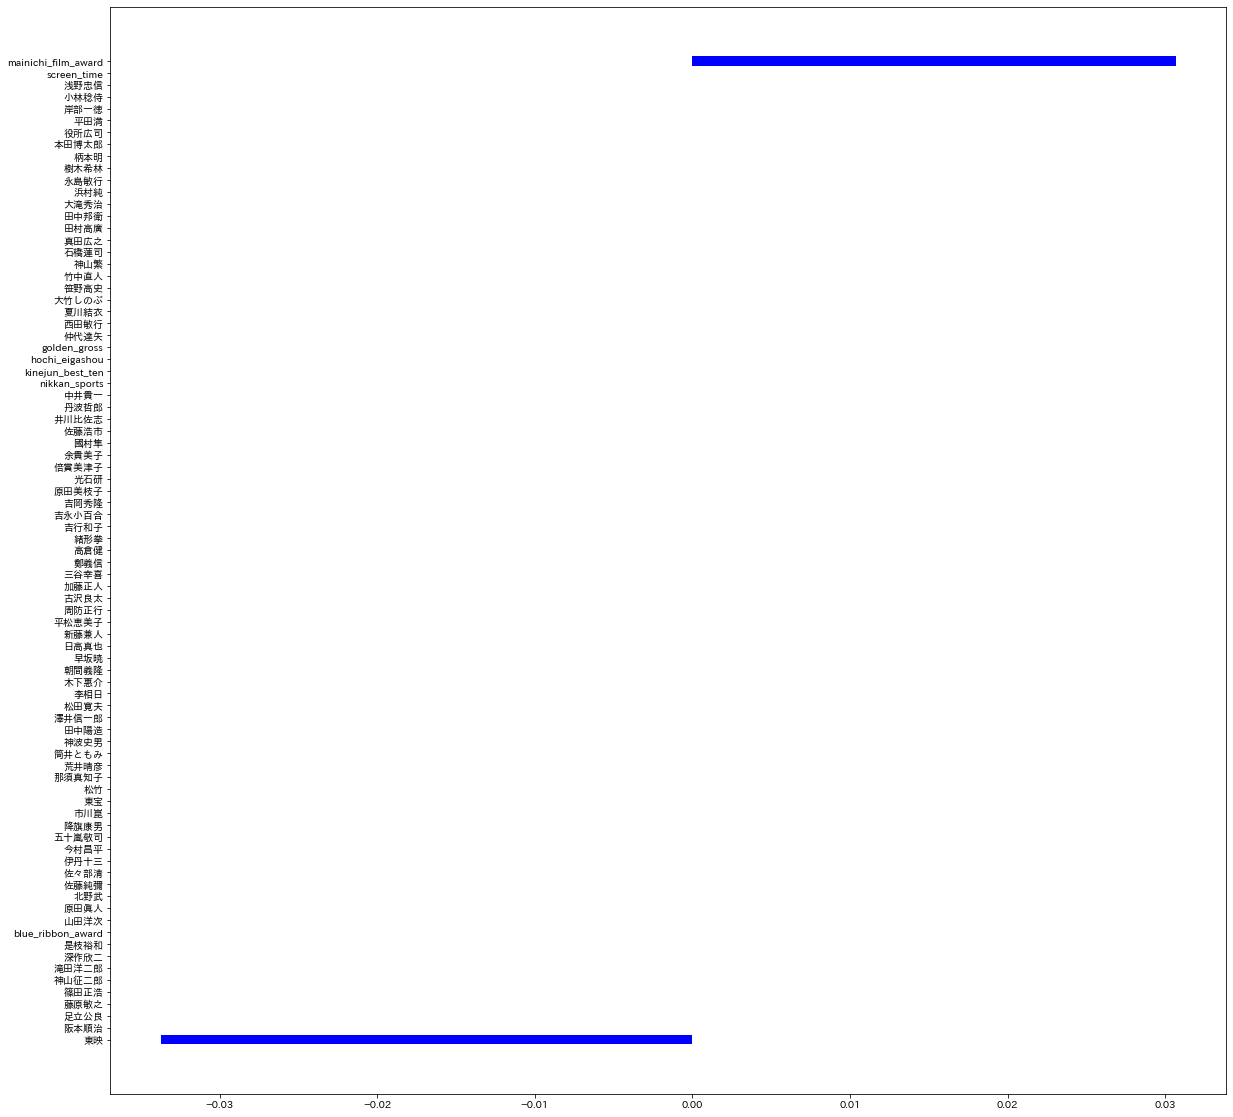

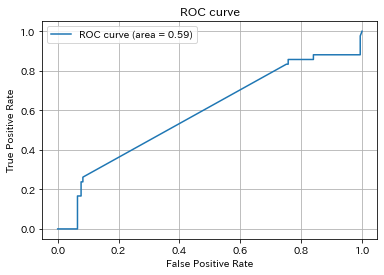

len: 211 , 211
confusion_matrix: 
[[102.  67.]
 [ 16.  26.]]
AUC: 
0.5868554522400676



In [40]:
if __name__ == "__main__":
    train()

In [ ]:
len: 211 , 211
confusion_matrix: 
[[104.  65.]
 [ 10.  32.]]
AUC: 
0.7686672302056917